# CAMKD
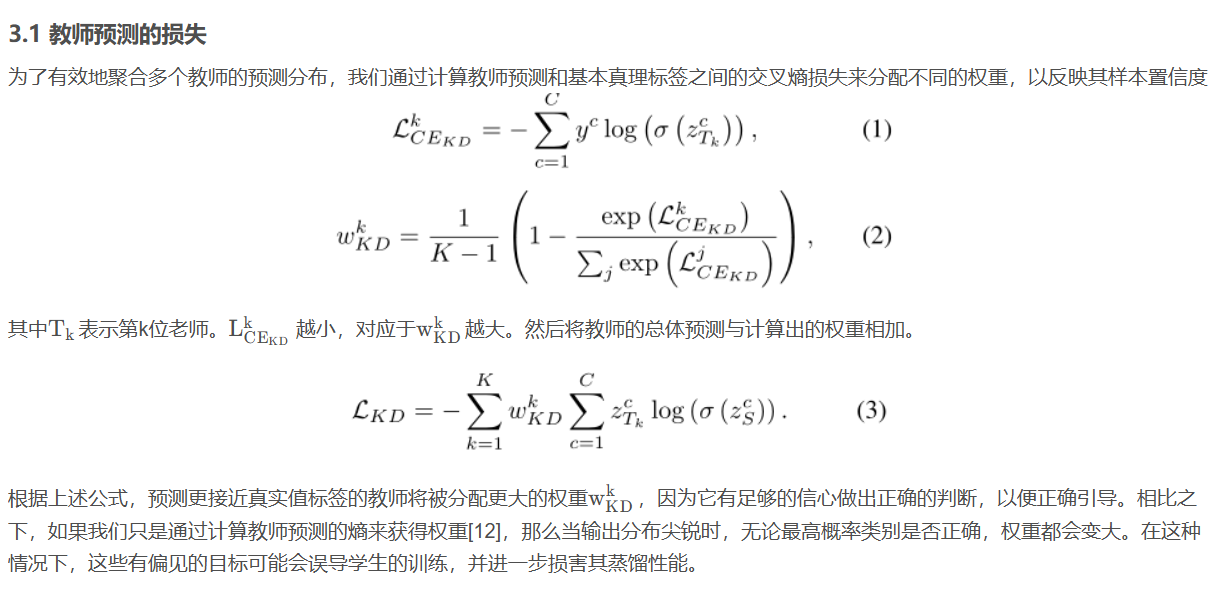

In [6]:
def forward(self, trans_feat_s_list, mid_feat_t_list, output_feat_t_list, target): 
        # 学生模型的中间特征列表、多教师模型的中间特征列表、多教师模型的输出特征列表、标签
    
        bsz = target.shape[0]


        loss_t = [self.crit_ce(logit_t, target) for logit_t in output_feat_t_list] 
        # 教师模型与标签的交叉熵损失，与中间层无关！以确定教师模型的权重
        num_teacher = len(trans_feat_s_list)
        loss_t = torch.stack(loss_t, dim=0) # 转化成张量 —— "reduction=none"
        weight = (1.0 - F.softmax(loss_t, dim=0)) / (num_teacher - 1)


        

        loss_st = [] #学生模型损失
        for mid_feat_s, mid_feat_t in zip(trans_feat_s_list, mid_feat_t_list):
            tmp_loss_st = self.crit_mse(mid_feat_s, mid_feat_t).reshape(bsz, -1).mean(-1)
            loss_st.append(tmp_loss_st)
        loss_st = torch.stack(loss_st, dim=0)
        loss = torch.mul(weight, loss_st).sum() 
        # 每个教师模型的损失进行的加权值（weight）
        # loss = torch.mul(attention, loss_st).sum()
        loss /= (1.0*bsz*num_teacher)

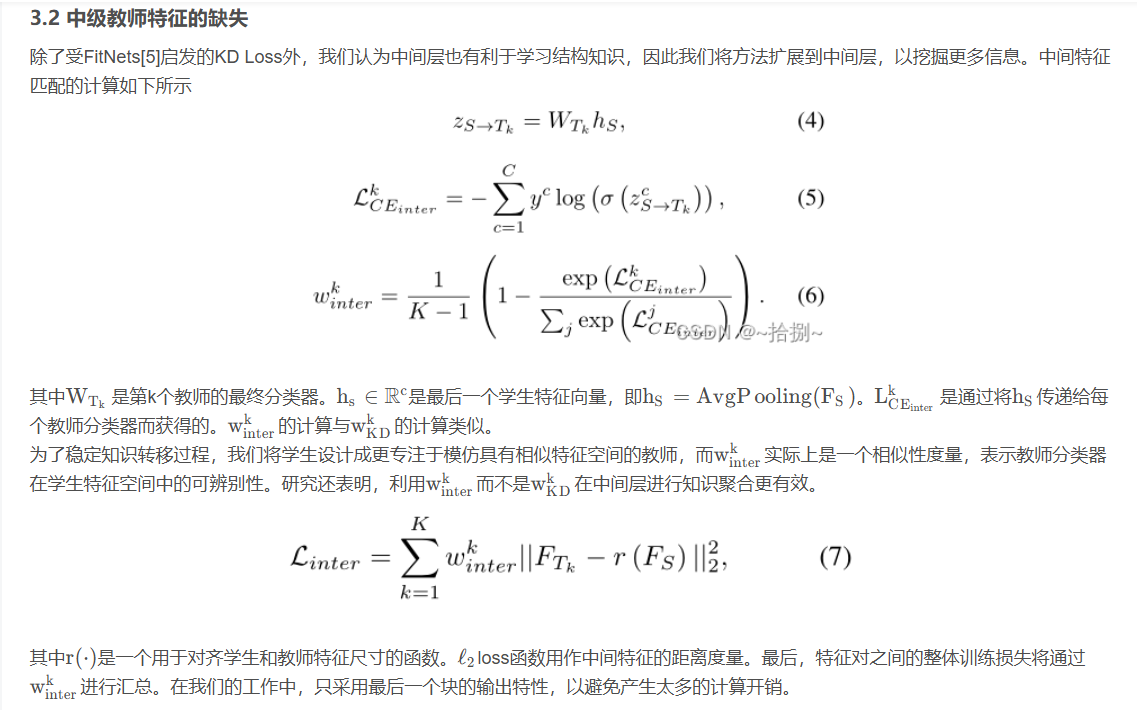

In [ ]:
loss_st = [] #学生模型损失
        for mid_feat_s, mid_feat_t in zip(trans_feat_s_list, mid_feat_t_list):
            tmp_loss_st = self.crit_mse(mid_feat_s, mid_feat_t).reshape(bsz, -1).mean(-1)
            loss_st.append(tmp_loss_st)
        loss_st = torch.stack(loss_st, dim=0)
        loss = torch.mul(weight, loss_st).sum() 
        # 每个教师模型的损失进行的加权值（weight）
        # loss = torch.mul(attention, loss_st).sum()
        loss /= (1.0*bsz*num_teacher)

# 这个 loss 就是L inter

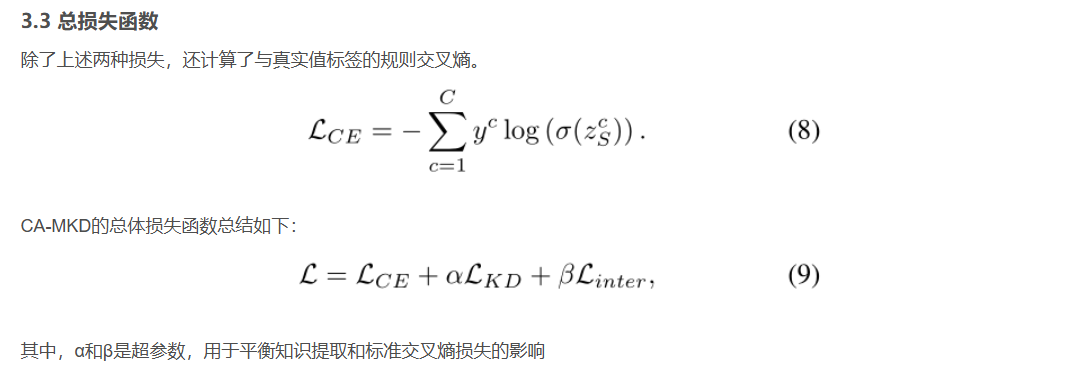

In [ ]:
# return loss, weight

# run.sh

In [ ]:
content of 'run.sh'

# cifar100 
# teacher
nohup python train_teacher.py --model resnet32x4 --gpu_id 0 --trial 0&

# student
# average
nohup python train_student.py --model_s vgg8 --teacher_num 3 --distill kd --ensemble_method AVERAGE_LOSS --nesterov -r 1 -a 1 -b 0  --trial 0 --gpu_id 4&
# FitNet-MKD
nohup python train_student.py --model_s vgg8 --teacher_num 3 --distill hint --ensemble_method AVERAGE_LOSS --nesterov -r 1 -a 1 -b 100  --trial 0 --gpu_id 3&
# EBKD
nohup python train_student.py --model_s vgg8 --teacher_num 3 --distill kd --ensemble_method EBKD --nesterov -r 1 -a 1 -b 0  --trial 0 --gpu_id 2&
# AEKD
nohup python train_student.py --model_s vgg8 --teacher_num 3 --distill kd --ensemble_method AEKD --nesterov -r 1 -a 1 -b 0 --trial 0  --gpu_id 1&
# CAMKD
nohup python train_student.py --model_s vgg8 --teacher_num 3 --distill inter --ensemble_method CAMKD --nesterov -r 1 -a 1 -b 50 --trial 0  --gpu_id 0&


#### teacher
nohup python train_teacher.py --model resnet32x4 --gpu_id 0 --trial 0&
训练一个ResNet32x4教师模型，使用第0号GPU。
nohup &：保证进程在后台运行，即使断开终端连接也能继续训练。
#### CAMKD
nohup python train_student.py --model_s vgg8 --teacher_num 3 --distill inter --ensemble_method CAMKD --nesterov -r 1 -a 1 -b 50 --trial 0  --gpu_id 0&
使用CAMKD（Channel Attention-based Multi-Teacher Knowledge Distillation）方法，注重特征之间的相互关系，通过通道注意力机制进行蒸馏。

# train_teacher

In [ ]:
import torch
ngpus_per_node = torch.cuda.device_count()
print(f"ngpus_per_node:{ngpus_per_node}")


ngpus_per_node:1


本机GPU数量为1，ngpus_per_node:1，multiprocessing_distributed不考虑。if-else结构中，只考虑else部分

#### num_workers
在数据加载器（DataLoader）中的 num_workers 参数决定了同时有多少个子进程用于加载数据。在深度学习中，数据加载和预处理往往是性能瓶颈，尤其是在训练大规模数据集时


#### TensorBoard

好用的可视化工具，vscode可以方便地使用。下面是示例代码：

In [ ]:
#示例代码：
import torch
from torch.autograd import Variable
import torch.nn.functional as functional
from tensorboardX import SummaryWriter

import matplotlib.pyplot as plt
import numpy as np

# x的shape大小
x = torch.from_numpy(np.linspace(-1, 1, 50).reshape([50, 1])).type(torch.FloatTensor)
# y的shape大小
y = torch.sin(x) + 0.2 * torch.rand(x.size())


class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        # Applies a linear transformation to the incoming data: :math:y = xA^T + b
        # 全连接层，公式为y = xA^T + b
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)

    def forward(self, x):
        # 隐含层的输出
        hidden_layer = functional.relu(self.hidden(x))
        output_layer = self.predict(hidden_layer)
        return output_layer


# 类的建立
net = Net(n_feature=1, n_hidden=10, n_output=1)

writer = SummaryWriter('runs')
graph_inputs = torch.from_numpy(np.random.rand(2, 1)).type(torch.FloatTensor)
writer.add_graph(net, (graph_inputs,))

# torch.optim是优化器模块
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# 均方差loss
loss_func = torch.nn.MSELoss()

for t in range(2000):
    prediction = net(x)
    loss = loss_func(prediction, y)

    # 反向传递步骤
    # 1、初始化梯度
    optimizer.zero_grad()
    # 2、计算梯度
    loss.backward()
    # 3、进行optimizer优化
    optimizer.step()

    writer.add_scalar('loss', loss, t)

writer.close()



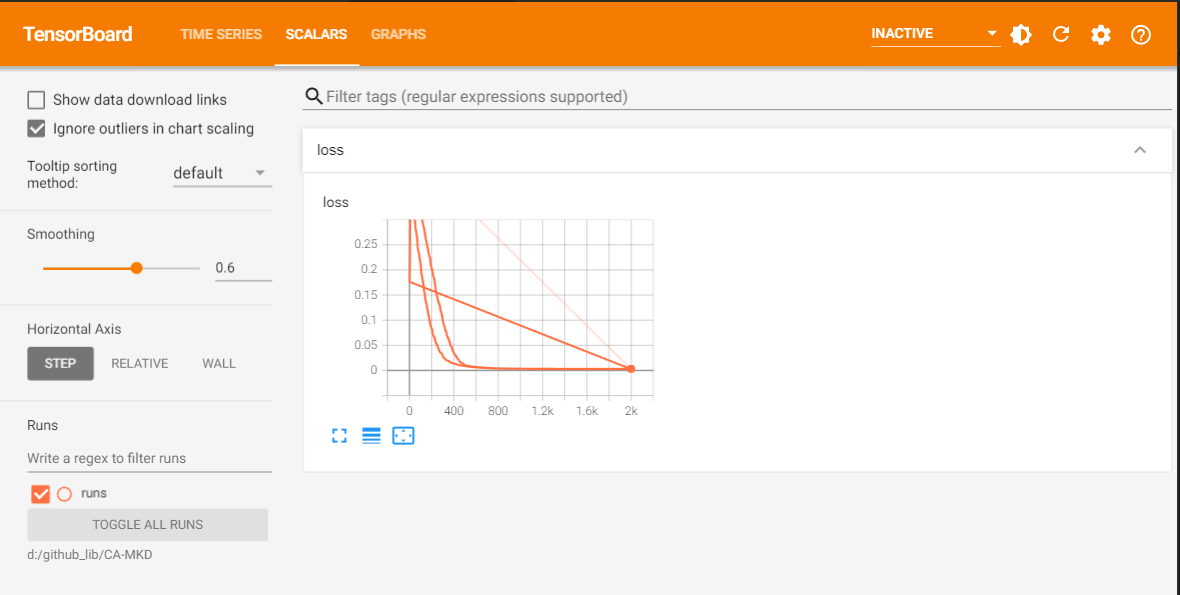

# train_student

In [ ]:
from dataset.cifar100 import get_cifar100_dataloaders, get_cifar100_dataloaders_sample
# 第二个提供采用参数，便于控制

#### 动态学习率

In [ ]:
from helper.util import adjust_learning_rate_cifar, save_dict_to_json, reduce_tensor, LAYER

def adjust_learning_rate_cifar(optimizer, epoch, opt):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    steps = np.sum(epoch > np.asarray(opt.lr_decay_epochs))
    if steps > 0:
        new_lr = opt.learning_rate * (opt.lr_decay_rate ** steps)
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr

'''
parser.add_argument('--lr_decay_epochs', type=str, default='150,180,210', help='where to decay lr, can be a list')
'''

#### 特征蒸馏思路：如何进行中间特征的提取

In [ ]:
  # 进行教师模型和学生模型的特征提取工作
    for model_t in model_t_list:
        model_t.eval()
    for model_t in model_t_list:
        feat_t, _ = model_t(data, is_feat=True)
        feat_t_list.append(feat_t)
    feat_s, _ = model_s(data, is_feat=True)

feat_t_list 是从教师模型 model_t_list 中的每个模型提取出来的中间特征.
feat_t 也是一个列表，包含了模型在不同网络层提取的特征张量。

#### 三种蒸馏方法：

In [ ]:
 if opt.distill == 'kd':
        criterion_kd = DistillKL(opt.kd_T)
    elif opt.distill == 'hint':
        criterion_kd = HintLoss()
        for i, feat_t in enumerate(feat_t_list):
            regress_s = ConvReg(feat_s[opt.hint_layer].shape,
                                feat_t[opt.hint_layer].shape)
            module_list.append(regress_s)
            trainable_list.append(regress_s)

    # 重点来看这个：
    elif opt.distill == 'inter':
        criterion_kd = CAMKD()
        feat_t_list = [feat_t[-2] for feat_t in feat_t_list] # 提取倒数第二层的特征 
        cal_weight = CalWeight(feat_s[-2], feat_t_list, opt) # 计算加权模块

        module_list.append(cal_weight)
        trainable_list.append(cal_weight)
    else:
        raise NotImplementedError(opt.distill)

靠近输出层的特征 [-2] 往往能够较好地概括全局信息。

##### CalWeight 类的定义：

In [ ]:
import torch.nn as nn
class CalWeight(nn.Module):
    def __init__(self, feat_s, feat_t_list, opt):
        super(CalWeight, self).__init__()

        self.opt = opt
        s_channel = feat_s.shape[1]
        for i in range(len(feat_t_list)):
            t_channel = feat_t_list[i].shape[1]
            setattr(self, 'embed'+str(i), Embed(s_channel, t_channel, self.opt.factor, self.opt.convs))

CalWeight 模块的目的是在知识蒸馏过程中，根据学生模型的特征（feat_s）和多个教师模型的特征（feat_t_list），创建一系列的嵌入映射模块（Embed）。每个嵌入模块都将学生的特征映射到相应的教师模型特征空间。

In [ ]:
class Embed(nn.Module):
    """Embedding module"""
    def __init__(self, dim_in=1024, dim_out=128, factor=2, convs=False):
        super(Embed, self).__init__()
        self.convs = convs
        if self.convs:
            self.transfer = nn.Sequential(
                nn.Conv2d(dim_in, dim_in//factor, kernel_size=1),
                nn.BatchNorm2d(dim_in//factor),
                nn.ReLU(inplace=True),
                nn.Conv2d(dim_in//factor, dim_in//factor, kernel_size=3, padding=1),
                nn.BatchNorm2d(dim_in//factor),
                nn.ReLU(inplace=True), 
                nn.Conv2d(dim_in//factor, dim_out, kernel_size=1),
                nn.BatchNorm2d(dim_out),
                nn.ReLU(inplace=True)              
            )
        else:
            self.transfer = nn.Sequential(
                nn.Conv2d(dim_in, dim_out, kernel_size=1),
                nn.BatchNorm2d(dim_out),
                nn.ReLU(inplace=True) 
            )


    def forward(self, x):
        x = self.transfer(x)
        return x

看不懂。。。

In [ ]:
if opt.dataset in ['cifar100']:
这种写法方便以后添加新的数据集比如['cifar100','fer2013']

In [ ]:
criterion_cls = nn.CrossEntropyLoss()
criterion_div = DistillKL(opt.kd_T) 

# 剩下的一个 criterion_kd 在上面三种蒸馏方法有提过

criterion_list = nn.ModuleList([])
criterion_list.append(criterion_cls)    # classification loss
criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
criterion_list.append(criterion_kd)     # other knowledge distillation loss

每一个epoch 的训练函数 ：

In [ ]:
'''utils.py Function:train_distill_multi_teacher'''
def train_distill_multi_teacher(epoch, train_loader, module_list, criterion_list, optimizer, opt):
    """One epoch distillation with multiple teacher"""
    # set modules as train()
    for module in module_list:
        module.train()
    # set teacher as eval()
    [model_t.eval() for model_t in module_list[-opt.teacher_num:]]

    criterion_cls = criterion_list[0]
    criterion_div = criterion_list[1]
    criterion_kd = criterion_list[2]

    model_s = module_list[0]
    # model_t = module_list[-1]
    model_t_list = module_list[-opt.teacher_num:]

    batch_time = AverageMeter() # 定义的
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    n_batch = len(train_loader) if opt.dali is None else (train_loader._size + opt.batch_size - 1) // opt.batch_size
    end = time.time()
    for idx, data in enumerate(train_loader):

        # ================prepare data==================
        data_time.update(time.time() - end)
        
        if opt.dali is None:
            input, target = data
        else:
            input, target = data[0]['data'], data[0]['label'].squeeze().long()
        input = input.float()

        if input.shape[0] < opt.batch_size:
            continue
        if opt.gpu is not None:
            input = input.cuda(opt.gpu if opt.multiprocessing_distributed else 0, non_blocking=True)
        if torch.cuda.is_available():
            target = target.cuda(opt.gpu if opt.multiprocessing_distributed else 0, non_blocking=True)

        # ===================forward=====================
        feat_s, logit_s = model_s(input, is_feat=True, preact=opt.preact)
        feat_t_list = []
        logit_t_list = []
        with torch.no_grad():
            for model_t in model_t_list:
                feat_t, logit_t = model_t(input, is_feat=True, preact=opt.preact)
                feat_t = [f.detach() for f in feat_t]
                feat_t_list.append(feat_t)
                logit_t_list.append(logit_t)

        # ================compute loss====================
        # cls + kl div
        loss_cls = criterion_cls(logit_s, target)
        # kl div
        if opt.ensemble_method == "AVERAGE_LOSS":
            loss_div_list = [criterion_div(logit_s, logit_t)
                             for logit_t in logit_t_list]
            loss_div = torch.stack(loss_div_list).mean(0)
        elif opt.ensemble_method == 'EBKD':
            loss_div_list = [criterion_div(logit_s, logit_t, is_ca=True)
                             for logit_t in logit_t_list]   
            entropy_list = [] 
            for logit_t in logit_t_list:
                softmax_logit_t = F.softmax(logit_t, dim=1)
                entropy  = -(softmax_logit_t)*(torch.log(softmax_logit_t))
                entropy_list.append(entropy.sum(1))    
            weight = []
            entropy_sum = torch.stack(entropy_list, dim=0).sum(dim=0).squeeze(dim=0)
            for entropy in entropy_list:
                weight.append(1.0 - (entropy / entropy_sum))
            loss_div = torch.stack(loss_div_list)
            weight = torch.stack(weight)
            bsz = loss_div.shape[1]
            loss_div = (torch.mul(weight, loss_div).sum()) / (1.0*bsz*opt.teacher_num)
        elif opt.ensemble_method == 'CAMKD': 
            # 这个最重要
            criterion_cls_lc = nn.CrossEntropyLoss(reduction='none')
            loss_t_list = [criterion_cls_lc(logit_t, target) for logit_t in logit_t_list]
            loss_t = torch.stack(loss_t_list, dim=0)
            attention = (1.0 - F.softmax(loss_t, dim=0)) / (opt.teacher_num - 1)
            loss_div_list = [criterion_div(logit_s, logit_t, is_ca=True)
                             for logit_t in logit_t_list]
            loss_div = torch.stack(loss_div_list, dim=0)
            bsz = loss_div.shape[1]
            loss_div = (torch.mul(attention, loss_div).sum()) / (1.0*bsz*opt.teacher_num)   
        elif opt.ensemble_method == "AEKD":
            loss_div_list = []
            grads = []
            logit_s.register_hook(lambda grad: grads.append(
                Variable(grad.data.clone(), requires_grad=False)))
            for logit_t in logit_t_list:
                optimizer.zero_grad()
                loss_s = criterion_div(logit_s, logit_t)
                loss_s.backward(retain_graph=True)
                loss_div_list.append(loss_s)

            scale = find_optimal_svm(torch.stack(grads),
                                     nu=opt.nu,
                                     gpu_id=opt.gpu,
                                     is_norm=opt.svm_norm)
            losses_div_tensor = torch.stack(loss_div_list)
            if torch.cuda.is_available():
                scale = scale.cuda(opt.gpu if opt.multiprocessing_distributed else 0, non_blocking=True)
                losses_div_tensor.cuda(opt.gpu if opt.multiprocessing_distributed else 0, non_blocking=True)
            loss_div = torch.dot(scale, losses_div_tensor)  
        else:
            raise NotImplementedError

        # other kd beyond KL divergence
        if opt.distill == 'kd':
            loss_kd = torch.zeros(1).float().cuda()
        elif opt.distill == 'hint':
            loss_hint_list = []
            f_s_list = [regress_s(feat_s[opt.hint_layer])
                        for regress_s in module_list[1:1+opt.teacher_num]]
            f_t_list = [f_t[opt.hint_layer] for f_t in feat_t_list]
            if opt.ensemble_method == "AVERAGE_LOSS":
                for f_s, f_t in zip(f_s_list, f_t_list):
                    loss_hint = criterion_kd(f_s, f_t)
                    loss_hint_list.append(loss_hint)
                loss_kd = torch.mean(torch.tensor(loss_hint_list))
                if torch.cuda.is_available():
                    loss_kd = loss_kd.cuda()            
            elif opt.ensemble_method == "AEKD":
                grads = []
                feat_s[opt.hint_layer].register_hook(lambda grad: grads.append(
                    Variable(grad.data.clone(), requires_grad=False)))
                for f_s, f_t in zip(f_s_list, f_t_list):
                    optimizer.zero_grad()
                    loss_hint = criterion_kd(f_s, f_t)
                    loss_hint.backward(retain_graph=True)
                    loss_hint_list.append(loss_hint)

                scale = find_optimal_svm(torch.stack(grads),
                                         nu=opt.nu,
                                         gpu_id=opt.gpu)

                loss_hint_tensor = torch.stack(loss_hint_list)
                if torch.cuda.is_available():
                    scale = scale.cuda()
                    loss_hint_tensor = loss_hint_tensor.cuda()
                loss_kd = torch.dot(scale, loss_hint_tensor)  
        elif opt.distill == 'inter': # 在这里那么 inter 表示结合的意思 ——>  对应CAMKD方法
            mid_feat_t_list = [feat_t[-2] for feat_t in feat_t_list]
            trans_feat_s_list, output_feat_t_list = module_list[1](feat_s[-2], mid_feat_t_list, model_t_list)
            loss_kd, weight = criterion_kd(trans_feat_s_list, mid_feat_t_list, output_feat_t_list, target)               
        else:
            raise NotImplementedError(opt.distill)

        if opt.distill_decay and epoch > (opt.epochs / 2):
            new_alpha = int(opt.epochs - epoch) /                                                         \
                int(opt.epochs / 2) * opt.alpha
            new_gamma = 1 - new_alpha

        else:
            new_alpha = opt.alpha
            new_gamma = opt.gamma
            new_beta = opt.beta

        if epoch == 1:
            loss = new_gamma * loss_cls + new_alpha * loss_div
        else:
            loss = new_gamma * loss_cls + new_alpha * loss_div + new_beta * loss_kd
      
      # 内容略 ...... 
    
    return top1.avg, top5.avg, losses.avg, data_time.avg

In [ ]:
else:
            new_alpha = opt.alpha
            new_gamma = opt.gamma
            new_beta = opt.beta

        if epoch == 1:
            loss = new_gamma * loss_cls + new_alpha * loss_div
        else:
            loss = new_gamma * loss_cls + new_alpha * loss_div + new_beta * loss_kd
        acc1, acc5 = accuracy(logit_s, target, topk=(1, 5))



参照文件最上面的论文中的内容，得到最终的损失。
#### summary：
代码值得学习的是CAMKD部分，其余部分不重要，定义loss的方法比较新颖，引用了置信度。